In [ ]:
!pip install -U pip
!pip install "numpy>=2.0" protobuf==4.25.3 mediapipe==0.10.14 opencv-python==4.10.0.84 matplotlib==3.8.4 pandas==2.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 111.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 50.8 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 142.2 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys, numpy as np, mediapipe as mp, cv2
print("✅ Stack OK")
print("Python:", sys.version.split()[0],
      "| NumPy:", np.__version__,
      "| OpenCV:", cv2.__version__)


✅ Stack OK
Python: 3.12.12 | NumPy: 2.0.2 | OpenCV: 4.10.0


In [ ]:
!apt -y install ffmpeg
!ffmpeg -y -i "{video_path}" -vcodec libx264 -acodec aac -pix_fmt yuv420p output.mp4
video_path = "output.mp4"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os, io, math, cv2, numpy as np, pandas as pd, mediapipe as mp, matplotlib.pyplot as plt
from google.colab import files

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils


In [ ]:
def angle_2d(a, b, c):
    a, b, c = np.asarray(a), np.asarray(b), np.asarray(c)
    ba, bc = a - b, c - b
    cosang = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-9)
    return np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

def moving_average(x, w=7):
    if len(x) < w: return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode='same')

def count_reps(signal, low_th, high_th):
    reps, state = 0, 'low'
    for v in signal:
        if state=='low' and v>high_th: state='high'
        elif state=='high' and v<low_th: state='low'; reps+=1
    return reps

LEFT  = {"shoulder":11, "elbow":13, "wrist":15, "hip":23}
RIGHT = {"shoulder":12, "elbow":14, "wrist":16, "hip":24}

def process_video(video_path, prefer_side="left", smooth_w=7):
    side = LEFT if prefer_side.lower()=="left" else RIGHT
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Nu pot deschide {video_path}. Dacă e .MOV/HEVC, convertește la .mp4 (H.264).")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False)
    t, elbow_deg, shoulder_deg = [], [], []
    i = 0

    while True:
        ok, frame = cap.read()
        if not ok: break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(rgb)
        if res.pose_landmarks:
            lm = res.pose_landmarks.landmark
            # dacă partea preferată nu e detectată bine, încearcă cealaltă
            s_idx = side["shoulder"]; e_idx = side["elbow"]; w_idx = side["wrist"]; h_idx = side["hip"]
            # fallback simplu: dacă scorurile sunt 0, swap
            if (lm[s_idx].visibility + lm[e_idx].visibility + lm[w_idx].visibility) < 0.3:
                side2 = RIGHT if side is LEFT else LEFT
                s_idx = side2["shoulder"]; e_idx = side2["elbow"]; w_idx = side2["wrist"]; h_idx = side2["hip"]

            S = np.array([lm[s_idx].x, lm[s_idx].y])
            E = np.array([lm[e_idx].x, lm[e_idx].y])
            W = np.array([lm[w_idx].x, lm[w_idx].y])
            H = np.array([lm[h_idx].x, lm[h_idx].y])

            elbow_deg.append(angle_2d(S,E,W))
            shoulder_deg.append(angle_2d(E,S,H))
            t.append(i / fps)
        i += 1

    cap.release(); pose.close()

    elbow_deg = np.array(elbow_deg, dtype=float)
    elbow_f   = moving_average(elbow_deg, w=smooth_w)
    ROM       = float(np.nanmax(elbow_f) - np.nanmin(elbow_f)) if len(elbow_f) else 0.0
    vel_s     = np.gradient(elbow_f) * fps if len(elbow_f) else np.array([])
    jerk_s    = np.gradient(np.gradient(elbow_f)) * (fps**2) if len(elbow_f) > 2 else np.array([])
    smoothness= float(np.mean(np.abs(jerk_s))) if len(jerk_s) else float('nan')

    if len(elbow_f):
        low_th  = np.nanmin(elbow_f) + 0.25 * ROM
        high_th = np.nanmin(elbow_f) + 0.75 * ROM
        reps    = int(count_reps(elbow_f, low_th, high_th))
    else:
        reps = 0

    df = pd.DataFrame({
        "time_s": t,
        "elbow_deg_raw": elbow_deg.tolist(),
        "elbow_deg_filt": elbow_f.tolist(),
        "shoulder_deg": (np.array(shoulder_deg, dtype=float)).tolist()
    })

    metrics = dict(
        video=os.path.basename(video_path),
        fps=float(fps),
        ROM=float(ROM),
        reps=int(reps),
        smoothness=float(smoothness),
        prefer_side=prefer_side.lower()
    )
    return metrics, df


In [ ]:
def annotate_video(input_path, output_path, prefer_side="left"):
    side = LEFT if prefer_side.lower()=="left" else RIGHT
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened(): raise RuntimeError(f"Nu pot deschide {input_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (w,h))

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1)
    font = cv2.FONT_HERSHEY_SIMPLEX

    while True:
        ok, frame = cap.read()
        if not ok: break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(rgb)
        if res.pose_landmarks:
            lm = res.pose_landmarks.landmark
            mp_drawing.draw_landmarks(frame, res.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            s_idx = side["shoulder"]; e_idx = side["elbow"]; w_idx = side["wrist"]
            if (lm[s_idx].visibility + lm[e_idx].visibility + lm[w_idx].visibility) < 0.3:
                side2 = RIGHT if side is LEFT else LEFT
                s_idx = side2["shoulder"]; e_idx = side2["elbow"]; w_idx = side2["wrist"]

            S = np.array([lm[s_idx].x, lm[s_idx].y])
            E = np.array([lm[e_idx].x, lm[e_idx].y])
            W = np.array([lm[w_idx].x, lm[w_idx].y])
            ang = angle_2d(S,E,W)

            text = f"Elbow: {ang:5.1f} deg"
            cv2.rectangle(frame, (10,10), (260,50), (0,0,0), -1)
            cv2.putText(frame, text, (20,40), font, 0.8, (255,255,255), 2, cv2.LINE_AA)

        out.write(frame)

    cap.release(); out.release(); pose.close()
    return output_path


In [ ]:

up = files.upload()
video_paths = list(up.keys())
print("Clipuri:", video_paths)

all_metrics = []
all_dfs = []
for vp in video_paths:
    m, df = process_video(vp, prefer_side="left", smooth_w=7)
    df["video"] = os.path.basename(vp)
    all_metrics.append(m)
    all_dfs.append(df)

combined = pd.concat(all_dfs, ignore_index=True)
combined.to_csv("metrics_all.csv", index=False)
print("saved metrics_all.csv")
pd.DataFrame(all_metrics)


Saving V3.mp4 to V3.mp4
Saving V2.mp4 to V2.mp4
Saving v1.mp4 to v1 (1).mp4
Clipuri: ['V3.mp4', 'V2.mp4', 'v1 (1).mp4']


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


📁 Am salvat metrics_all.csv


,video,fps,ROM,reps,smoothness,prefer_side
0,V3.mp4,29.975470,163.499124,5,845.517471,left
1,V2.mp4,29.976762,154.420150,9,739.138370,left
2,v1 (1).mp4,30.000000,147.142479,5,998.922873,left


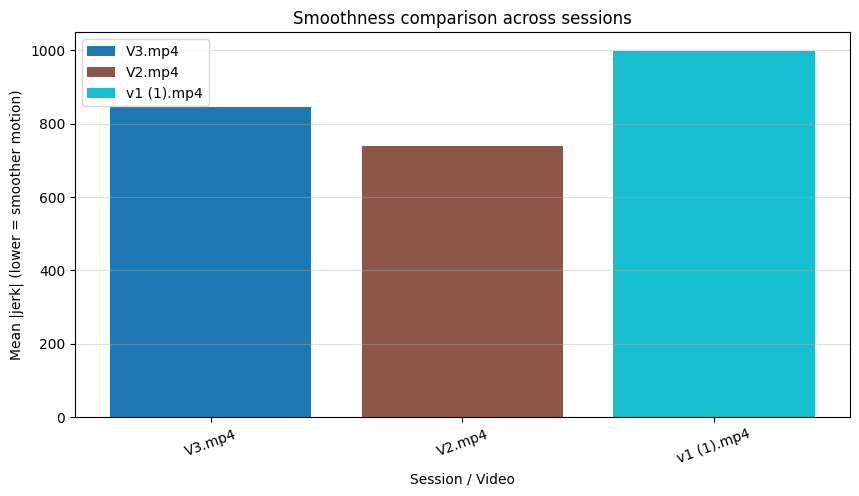

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.tab10(np.linspace(0, 1, len(all_metrics)))

plt.figure(figsize=(10,5))
for i, m in enumerate(all_metrics):
    plt.bar(i, m["smoothness"], color=colors[i], label=m["video"])

plt.xlabel("Session / Video")
plt.ylabel("Mean |jerk| (lower = smoother motion)")
plt.title("Smoothness comparison across sessions")
plt.xticks(range(len(all_metrics)), [m["video"] for m in all_metrics], rotation=20)
plt.legend()
plt.grid(axis='y', alpha=0.4)
plt.show()


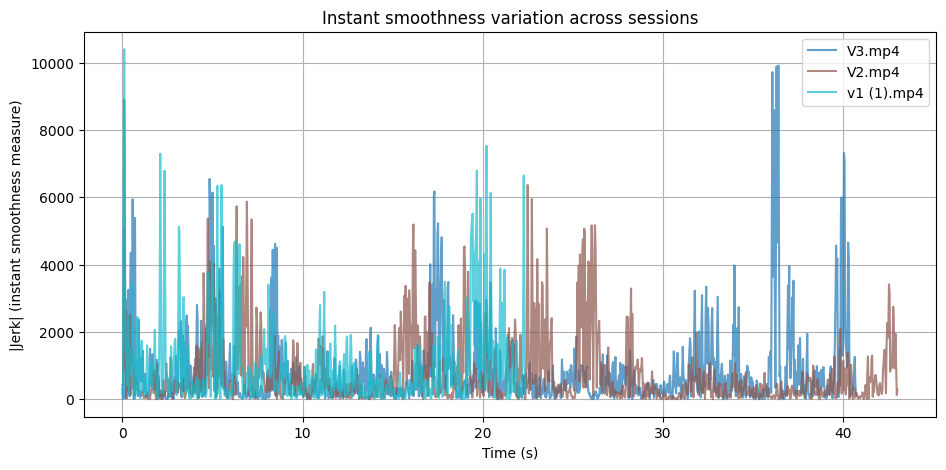

In [ ]:
plt.figure(figsize=(11,5))
colors = plt.cm.tab10(np.linspace(0, 1, len(all_dfs)))

for i, vid in enumerate(combined["video"].unique()):
    sub = combined[combined["video"]==vid]
    jerk = np.gradient(np.gradient(sub["elbow_deg_filt"])) * (30.0**2)  # fps=30
    smoothness_inst = np.abs(jerk)  # |jerk| = neregularitate instantanee

    plt.plot(sub["time_s"], smoothness_inst, label=vid, color=colors[i], alpha=0.7)

plt.xlabel("Time (s)")
plt.ylabel("|Jerk| (instant smoothness measure)")
plt.title("Instant smoothness variation across sessions")
plt.grid(True)
plt.legend()
plt.show()


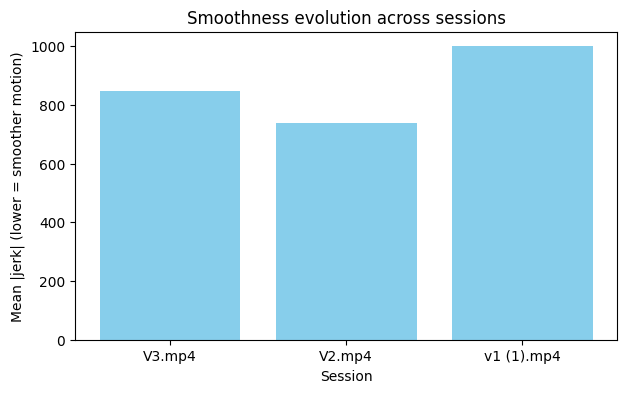

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar([m['video'] for m in all_metrics], [m['smoothness'] for m in all_metrics], color='skyblue')
plt.title("Smoothness evolution across sessions")
plt.ylabel("Mean |jerk| (lower = smoother motion)")
plt.xlabel("Session")
plt.show()


In [ ]:
annotate_video("V3.mp4", "nume_video_annotated.mp4")


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


'nume_video_annotated.mp4'

In [ ]:

from openai import OpenAI
client = OpenAI(api_key="token jmeker")

prompt = f"""
The patient performed stroke rehabilitation exercises.
Results: ROM={ROM:.1f}°, {reps} repetiții valide, smoothness={smoothness:.4f}.
Based on the results give a shorter feedback.
"""

resp = client.responses.create(model="gpt-4o-mini", input=prompt)
print(resp.output_text)


Great job on your stroke rehabilitation exercises! You've achieved a range of motion of 146.1°, completed 5 valid repetitions, and demonstrated smoothness of 721.99. Keep up the excellent work and maintain this progress!
